In [3]:
# Import general utilities
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Import TDA utilities
from ripser import Rips
from tadasets import torus, sphere
from persim.landscapes import PersLandscapeExact
from persim.landscapes import plot_landscape_simple
from persim.landscapes import PersistenceLandscaper
from persim import plot_diagrams

# Import Scikit-Learn tools
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [4]:
data_torus = torus(n=100, c=2, a=1)
data_sphere = sphere(n=100, r=2)

rips = Rips(maxdim = 2)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [6]:
dgms_torus = rips.fit_transform(data_torus)
dgms_sphere = rips.fit_transform(data_sphere)

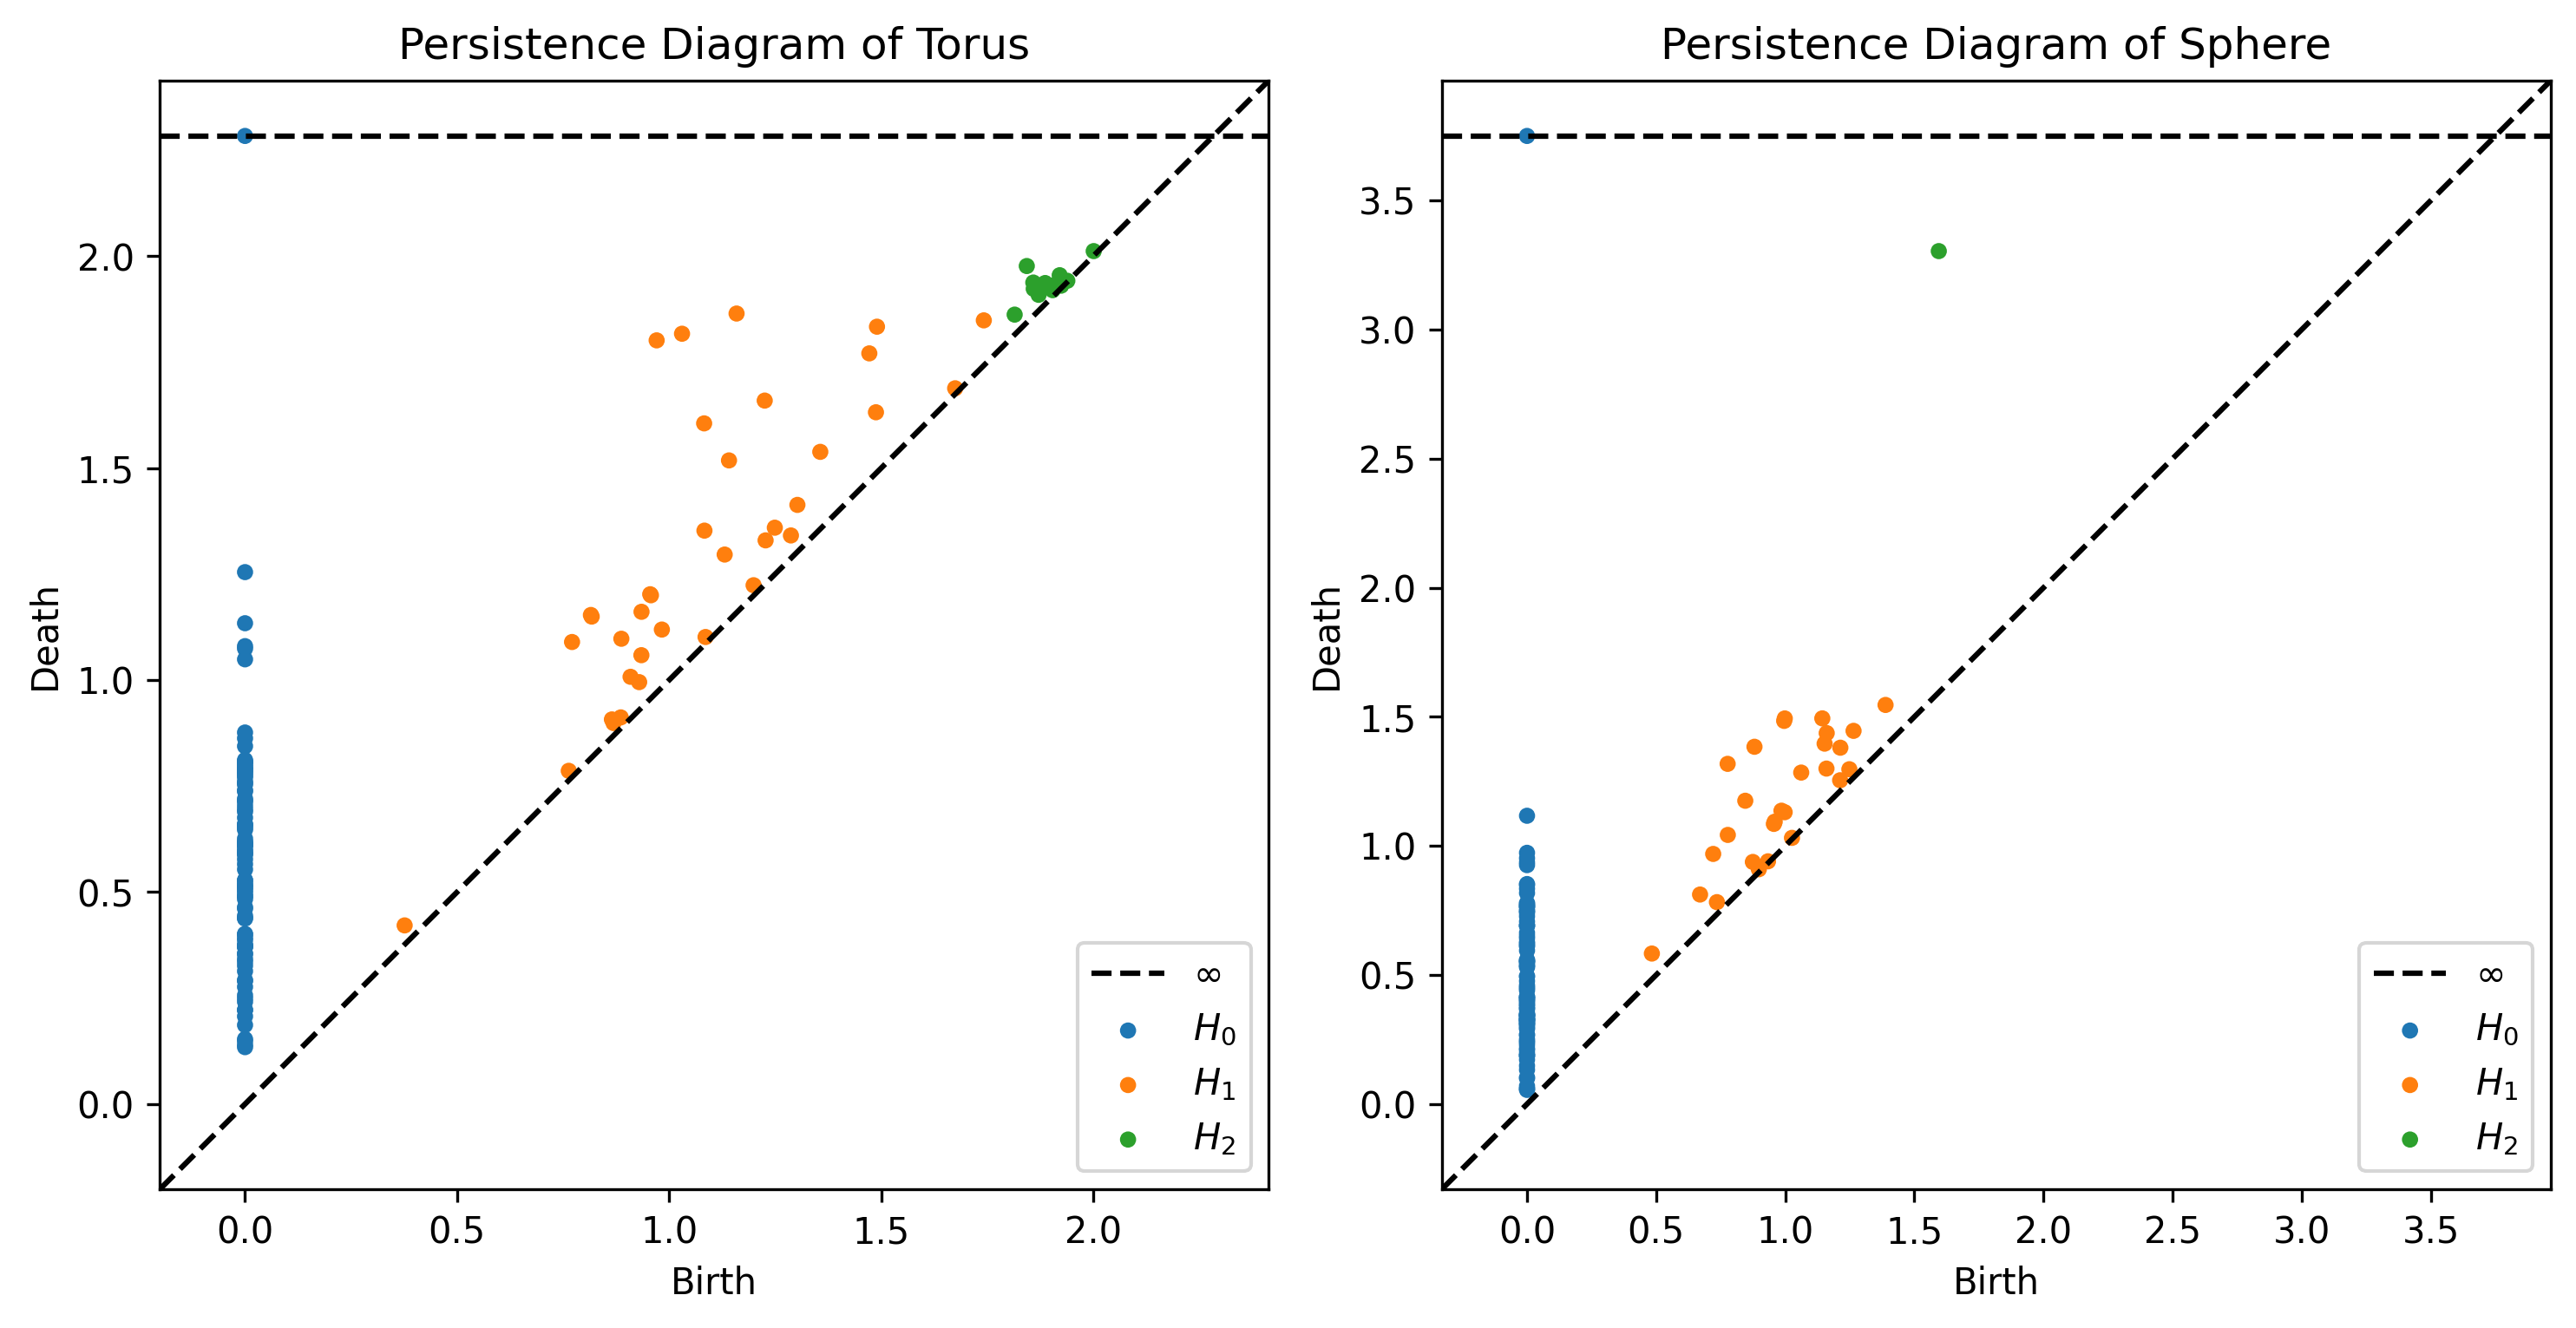

In [7]:
fig, axs = plt.subplots(1, 2, dpi=300)
fig.set_size_inches(10, 5)

plot_diagrams(dgms_torus, title="Persistence Diagram of Torus", ax=axs[0])

plot_diagrams(dgms_sphere, title="Persistence Diagram of Sphere", ax=axs[1])

fig.tight_layout()

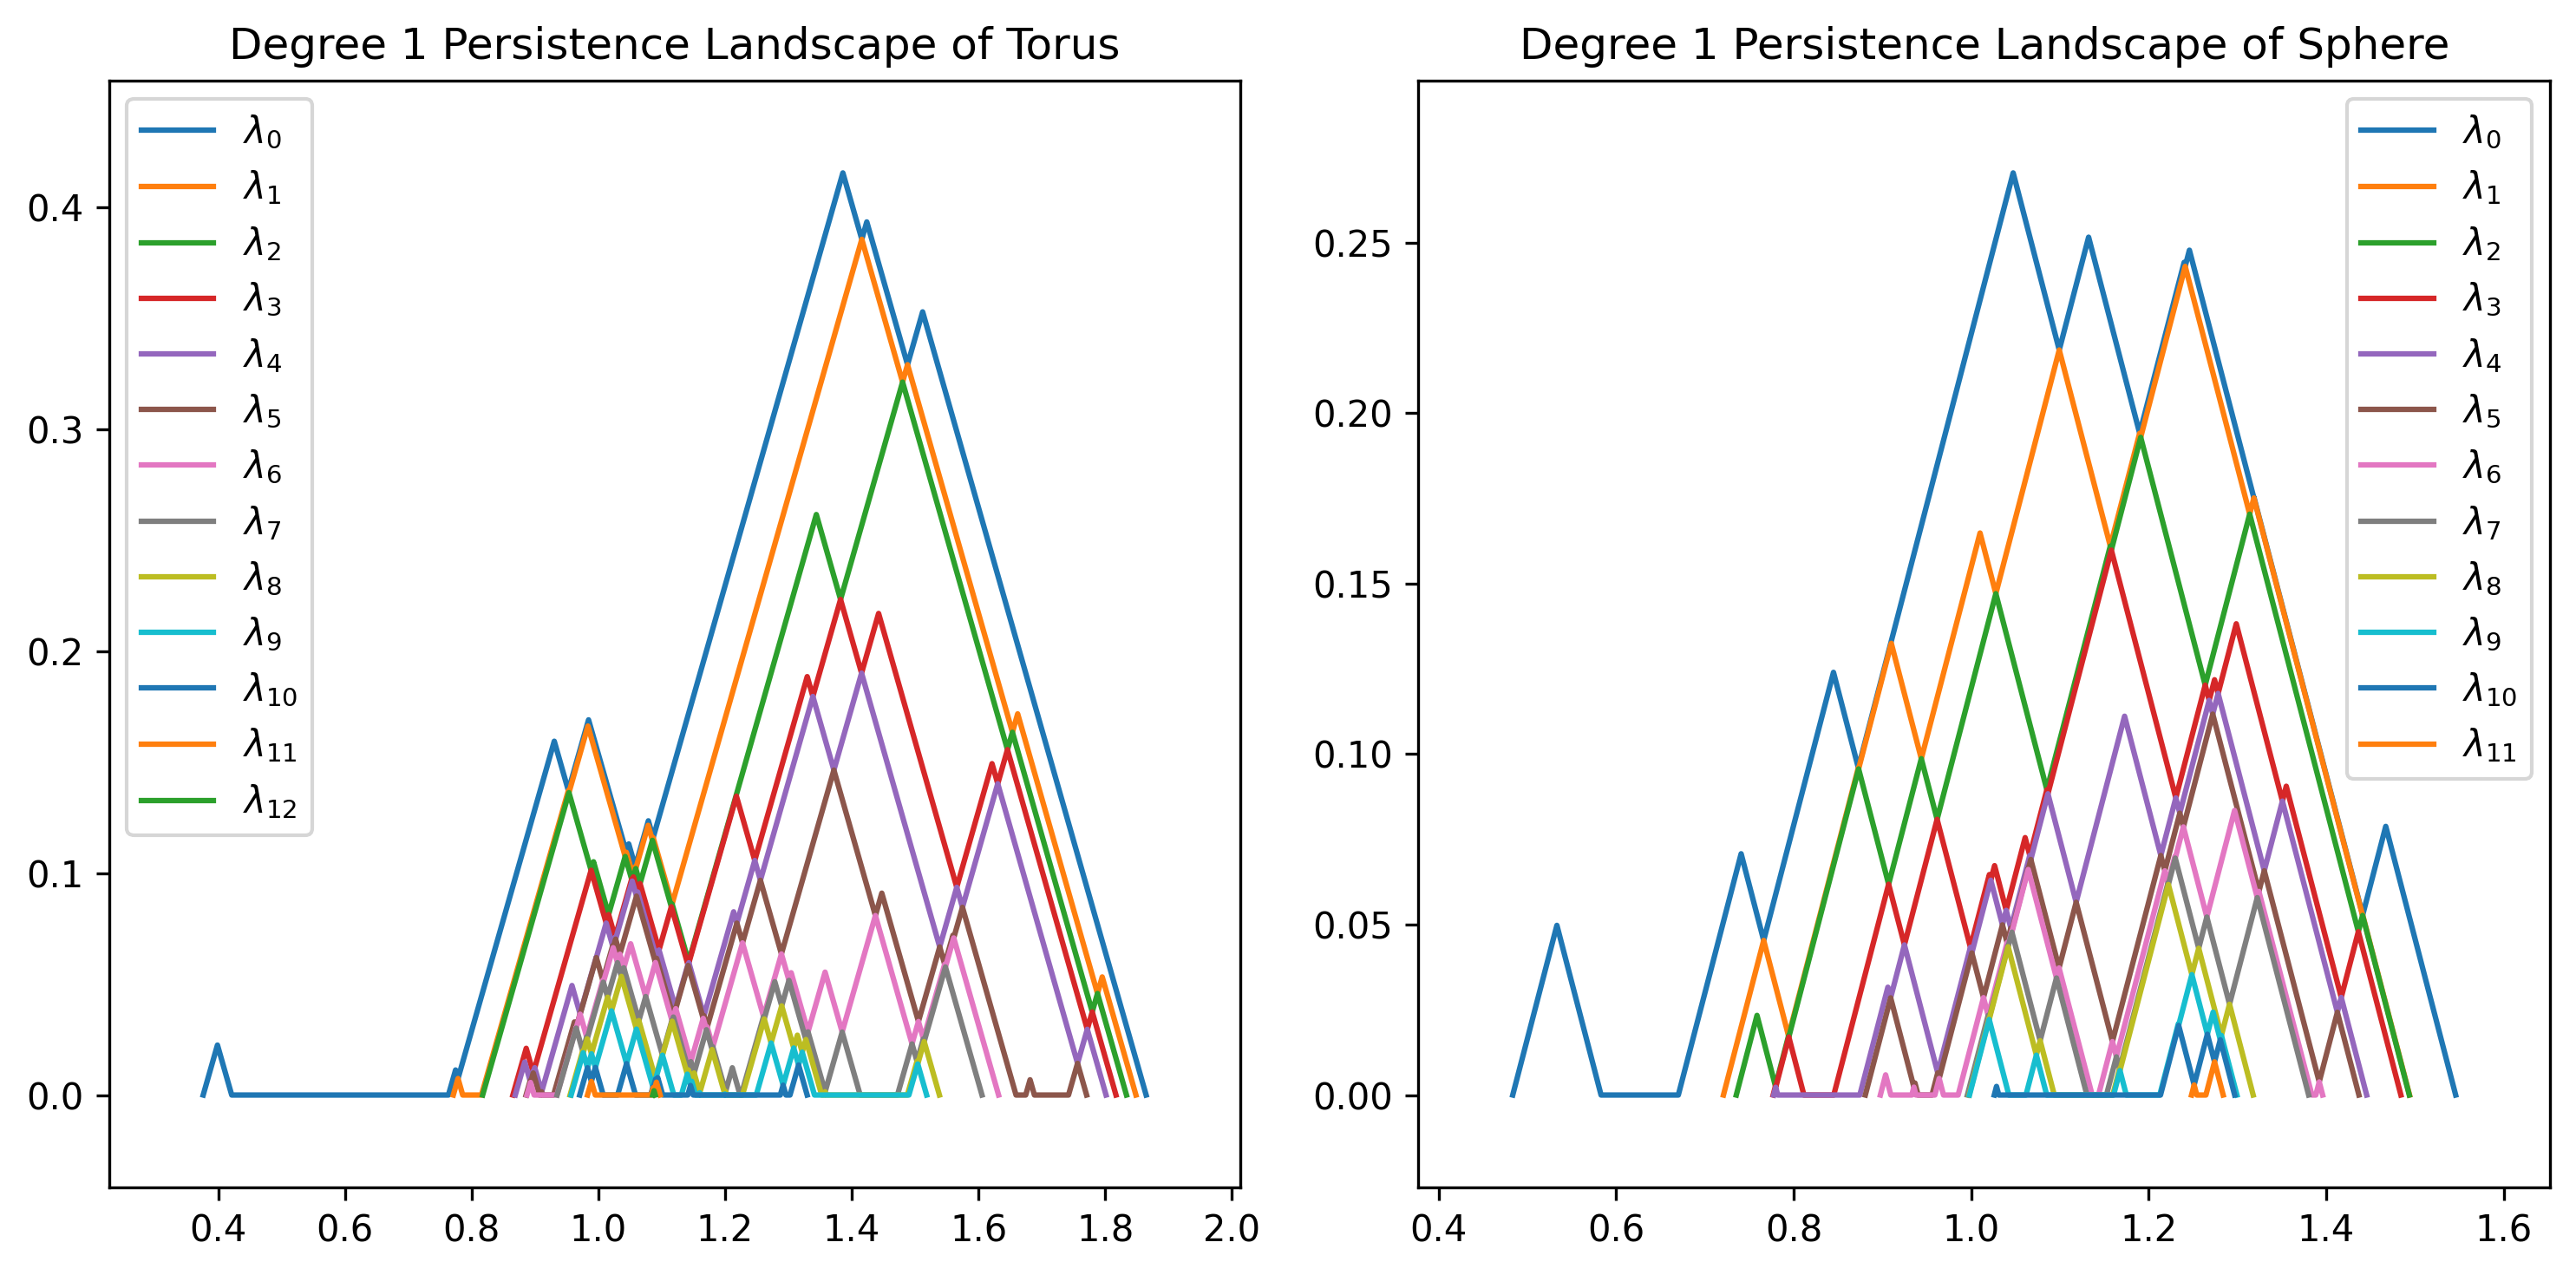

In [8]:
fig, axs = plt.subplots(1, 2, dpi=300)
fig.set_size_inches(10, 5)

plot_landscape_simple(PersLandscapeExact(dgms_torus, hom_deg=1),
                             title="Degree 1 Persistence Landscape of Torus", ax=axs[0])

plot_landscape_simple(PersLandscapeExact(dgms_sphere, hom_deg=1),
                            title="Degree 1 Persistence Landscape of Sphere", ax=axs[1])

fig.tight_layout()

In [ ]:
landscapes_torus = []
landscapes_sphere = []

for i in range(100):

    _data_torus = torus(n=100, c=2, a=1)
    _data_sphere = sphere(n=100, r=2)

    # Compute persistence diagrams
    dgm_torus = rips.fit_transform(_data_torus)
    dgm_sphere = rips.fit_transform(_data_sphere)

    # Instantiate persistence landscape transformer
    torus_landscaper = PersistenceLandscaper(hom_deg=1, start=0, stop=2.0, num_steps=500, flatten=True)
    sphere_landscaper = PersistenceLandscaper(hom_deg=1, start=0, stop=2.0, num_steps=500, flatten=True)

    # Compute flattened persistence landscape
    torus_flat = torus_landscaper.fit_transform(dgm_torus)
    sphere_flat = sphere_landscaper.fit_transform(dgm_sphere)

    landscapes_torus.append(torus_flat)
    landscapes_sphere.append(sphere_flat)

landscapes_torus = np.array(landscapes_torus, dtype=object)
landscapes_sphere = np.array(landscapes_sphere, dtype=object)

print('Torus:', np.shape(landscapes_torus))
print('Sphere:', np.shape(landscapes_sphere))

Torus: (100,)
Sphere: (100,)


In [ ]:
# Find maximal length
u = np.max([len(a) for a in landscapes_torus])
v = np.max([len(a) for a in landscapes_sphere])

w = np.max([u,v])

# Instantiate zero-padded arrays
ls_torus = np.zeros((100, w))
ls_sphere = np.zeros((100, w))

# Populate arrays
for i in range(len(landscapes_torus)):
    ls_torus[i, 0:len(landscapes_torus[i])] = landscapes_torus[i]
    ls_sphere[i, 0:len(landscapes_sphere[i])] = landscapes_sphere[i]

print('Torus:', ls_torus.shape)
print('Sphere:', ls_sphere.shape)

Torus: (100, 8500)
Sphere: (100, 8500)


In [15]:
pca_torus = PCA(n_components=2)
pca_sphere = PCA(n_components=2)

pca_torus.fit_transform(ls_torus)
pca_sphere.fit_transform(ls_sphere)

comp_torus = pca_torus.components_
comp_sphere = pca_sphere.components_

print('Singular values for torus dataset:', pca_torus.singular_values_)
print('Singular values for sphere dataset:', pca_sphere.singular_values_)

Singular values for torus dataset: [10.91439173 10.150534  ]
Singular values for sphere dataset: [12.56373306  9.47984231]


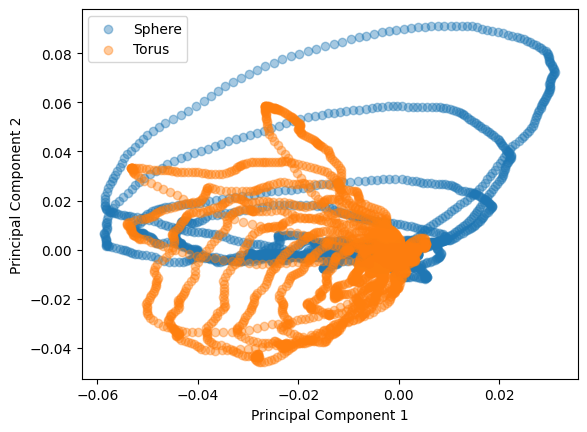

In [16]:
# Plot projection of data onto the first two principal components
plt.figure()
plt.scatter(comp_sphere[0], comp_sphere[1], label='Sphere', alpha=0.4)
plt.scatter(comp_torus[0], comp_torus[1], label='Torus', alpha=0.4)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

In [ ]:
# Produce lists of points
pts_torus = [[comp_torus[0,i], comp_torus[1,i]] for i in range(len(comp_torus[0]))] # first component is comp_torus[0]
pts_sphere = [[comp_sphere[0,i], comp_sphere[1,i]] for i in range(len(comp_sphere[0]))]

# Instantiate indicator functions
chi_torus = np.zeros(len(pts_torus))
chi_sphere = np.ones(len(pts_sphere))

# Produce final list of points
pts = []

for p in pts_torus:
    pts.append(p)

for p in pts_sphere:
    pts.append(p)

pts = np.array(pts)

# Append indicator functions
chi = np.hstack((chi_torus, chi_sphere))

In [19]:
# Split points and indicator arrays
P_train, P_test, c_train, c_test = train_test_split(pts, chi, train_size=.8)

# Instantiate support vector classifier
clf = svm.SVC()

# Fit model
clf.fit(P_train, c_train)

# Evaluate model performance using accuracy between ground truth data and predicted data
print(f'Model accuracy: {metrics.accuracy_score(c_test, clf.predict(P_test)):.2f}')

Model accuracy: 0.58
